# Tutorial One: One-way ANOVA

## 实验前的准备

本次实验我们载入一些Python的安装包，如下：

In [29]:
import os # 修改工作目录

import numpy as np
import pandas as pd
import scipy.stats as stats # 统计函数
import matplotlib.pyplot as plt
from plotnine import * # ggplot 绘图
from plotnine.data import mpg
from jupyterquiz import display_quiz # Quiz

#from ggplot import ggplot

import math

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f
from scipy.stats import t
from statsmodels.stats.stattools import durbin_watson



## 背景
现在有三种不同的饮食方式，分别记为A、B和C。不同的饮食方式对人体重变化的影响可能是不同的。我们招募了72名志愿者参与这个这次实验。实验采用**双盲**的方式，随机分配志愿者到一种饮食方式。
注：
**双盲实验**：研究对象和研究者都不了解试验分组情况，而是由研究设计者来安排和控制全部试验。

## 数据
数据集Data_1是我们本次采集的数据，具体形式如下所示。

In [30]:
print('Data 1 is shown as follows: \n', pd.read_csv("./Data/Data_1.csv"))

Data 1 is shown as follows: 
     gender  age  height diet.type  initial.weight  final.weight
0   Female   22     159         A              58          54.2
1   Female   46     192         A              60          54.0
2   Female   55     170         A              64          63.3
3   Female   33     171         A              64          61.1
4   Female   50     170         A              65          62.2
..     ...  ...     ...       ...             ...           ...
67    Male   35     183         C              83          80.2
68    Male   49     177         C              84          79.9
69    Male   28     164         C              85          79.7
70    Male   40     167         C              87          77.8
71    Male   51     175         C              88          81.9

[72 rows x 6 columns]


在Data_1这个数据集中共有72名志愿者的基本信息，包括：性别、年龄和身高，以及参与本次实验的信息，包括饮食方式、参与实验前的体重和6周后的体重。

## 任务

在本次实验中，我们需要解决以下四个问题：

- 比较 A 和 B 两种饮食方式对减重的影响是否存在差异？
- 利用单因素方差分析模型，比较三种饮食方式对减重的影响是否存在差异？
- 给出单因素方差分析模型中参数的估计值，并阐述其含义。
- 请说明所使用的模型的合理性。

注：本实验中的显著性水平为 $\alpha = 0.05$。

## 解决方案

### 数据预处理

In [31]:
alpha = 0.05 # significant level
a = 3 # number of levels
m = 24 # number of replicates
n = a*m # sample size

- 响应变量

我们关心的是志愿者参与此次实验前后的体重差异，即志愿者参与实验前的体重减去6周时的体重。

In [32]:
## Load Data
Data = pd.read_csv("./Data/Data_1.csv")
print(Data.columns)# Print the column names of Data_1

Index(['gender', 'age', 'height', 'diet.type', 'initial.weight',
       'final.weight'],
      dtype='object')


In [33]:
## Construct a New Dataset
Data = Data[['diet.type','initial.weight','final.weight']] # select some columns from a dataset
Data['weight.loss'] = Data['initial.weight'] - Data['final.weight']
Data = Data.drop(labels=['initial.weight', 'final.weight'], axis = 1) # delete some columns from a dataset
Data.columns = ['Diet_type','Weight_loss']
print(Data)

   Diet_type  Weight_loss
0          A          3.8
1          A          6.0
2          A          0.7
3          A          2.9
4          A          2.8
..       ...          ...
67         C          2.8
68         C          4.1
69         C          5.3
70         C          9.2
71         C          6.1

[72 rows x 2 columns]


这样我们构造了一个合适的数据集，其中包括两列的数据。第一列指的是每一名志愿者所被分配的饮食方式，其取值分别为A，B 和 C。第二列指的是每一名志愿者经过6周的观察后体重的减少量。

### Task1: 比较 A 和 B 两种饮食方式对减重的影响是否存在差异？

我们先来看一下数据是怎样的？

In [34]:
Data["Diet_type"].value_counts()
index_delete = Data[(Data["Diet_type"] == "C")].index.tolist()
Data1 = Data.drop(index = index_delete)
print(Data1)

   Diet_type  Weight_loss
0          A          3.8
1          A          6.0
2          A          0.7
3          A          2.9
4          A          2.8
5          A          2.0
6          A          2.0
7          A          8.5
8          A          1.9
9          A          3.1
10         A          1.5
11         A          3.0
12         A          3.6
13         A          0.9
14         B         -2.1
15         B          2.0
16         B          1.7
17         B          4.3
18         B          0.6
19         B          2.7
20         B          3.6
21         B          3.0
22         B          2.0
23         B          4.2
24         B          4.7
25         B          3.3
26         B         -0.5
39         A         -0.6
40         A          1.1
41         A          4.5
42         A          4.1
43         A          9.0
44         A          2.4
45         A          3.9
46         A          3.5
47         A          5.1
48         A          3.5
49         B

我们绘制一张图来刻画两种饮食方式下体重变化量的“分布”，如下图。

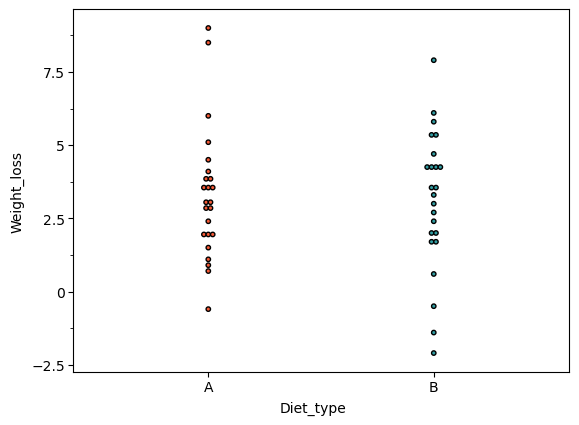

<ggplot: (8756414928674)>

In [35]:
(ggplot(Data1, aes(x="Diet_type",y="Weight_loss",fill="Diet_type"))
         + geom_dotplot(binaxis = "y", stackdir = "center", binwidth = 0.15, show_legend = False)
         + scale_fill_hue(s = 0.90, l = 0.60, h = 0.05, color_space = 'husl')
         + theme_matplotlib())

在上图中，可以从直观上比较两种饮食方式对体重变化量的影响。对于采用饮食方式A，志愿者的体重变化量集中在$3$附近，但有两个较大的数值；对于采用饮食方式B，志愿者的体重变化量集中在$4$附近，但也有三个负值。感觉上，两种饮食方式是有区别的。但是，这种“区别”会否是由于志愿者个体差异所造成的？还是这种“区别”是明显地有别于个体差异的？我们仍需要用量化的手段加以衡量。为了比较两组数据是否存在差异，一种常用的方法是二样本独立$t$检验。

接下来，我们回顾一下二样本独立$t$检验。

假定第一组数据$x_1,x_2,\cdots,x_m$来自一个正态分布$N(\mu_1,\sigma^2)$，第二组数据$y_1,y_2,\cdots,y_n$来自另一个正态分布$N(\mu_2,\sigma^2)$，并且这两个正态分布是相互独立的。于是，比较两组数据差异的问题，就转化为比较两个总体均值差异的问题。通常，我们会考虑这样的一对假设，即原假设和备择假设分别为
$$
H_0: \mu_1 = \mu_2, \quad \text{vs} \quad H_1: \mu_1\neq \mu_2.
$$
为解决这个问题，我们构建了一个检验统计量为
$$
t_0 = \frac{ (\bar{x} - \bar{y})}{\sqrt{s_w^2 (m^{-1} + n^{-1})}}.
$$
其中，
- $\bar{x} = m^{-1} \sum_{i=1}^m x_i$表示第一组的样本均值；
- $\bar{y} = n^{-1} \sum_{i=1}^n y_i$表示第二组的样本均值；
- $s_w^2 = \frac{(m-1)\sum{i=1}^{m}(x_i-\bar{x})^2 + (n-1)\sum_{i=1}^n (y_i-\bar{y})^2}{m+n-2}$表示两组样本的合方差。

可以证明，在原假设成立的情况下，$t \sim t(m+n-2)$。于是，我们可以构造拒绝域为$\{|t_0| > t_{1-\alpha/2}(m+n-2)\}$。当样本落入拒绝域时，则拒绝原假设；反之，则无法拒绝原假设。除了构造拒绝域这一方法之外，我们还可以计算其$p$值，即
$$
p = 2\times P(t_{m+n-2} > |t_0|) .
$$
如果$p$值小于显著性水平$\alpha$，则拒绝原假设；反之，则无法拒绝原假设。

注：在这个问题中，$m=n=24$。

In [36]:
# Reconstruct a dataset
Data2 = Data1.values
list_type = ["A","B"]
Group2_data = [Data2[Data2[:,0] == x,1] for x in list_type]
# Two-sample t test
t0,pVal0 = stats.ttest_ind(Group2_data[0],Group2_data[1])

首先，我们可以计算 $t$ 检验统计量为

In [37]:
print("t statistic is:" ,round(t0,4))

t statistic is: 0.2805


与其相应的临界值进行比较，即$t_{1-\alpha/2}(m+n-2)$为

In [38]:
print("critical value is：", round(t.ppf(1-alpha/2,24*2-2),4))

critical value is： 2.0129


我们发现，$t$ 检验统计量的绝对值比临界值小得多，所以，无法拒绝原假设，也就是说，这两种饮食方式对体重的变化的影响无显著差异。

除了上述方法之外，我们仍可以采用 $p$ 值来得到结论。具体来说，我们可以计算 $p$ 值为

In [39]:
print("p-value is:", round(pVal0,4))

p-value is: 0.7804


由于 $p$ 值比显著性水平 $\alpha$ 大，所以，无法拒绝原假设。

### Task2: 利用单因素方差分析模型，比较三种饮食方式对减重的影响是否存在差异？

与Q1类似，Q2本质上可转化为，对于采用不同饮食方式的志愿者，他们的体重变化量分布是否存在差异？对于 $a=2$ 组样本的均值比较，最为常用的方法是 $t$ 检验。然而，对于$a\geq 2$时，更为一般的方法是**单因素方差分析模型**。

这里我们简单介绍一下单因素方差分析模型（One-way ANOVA 模型）。

假设有 $a$ 组数据，每组数据有 $m$ 个，于是，共有 $n = am$ 个数据。对于第$i$组的数据而言，我们将数据记为$y_{i1},y_{i2},\cdots,y_{ij},\cdots,y_{im}$。
在方差分析模型中，我们假定:

（1）每一个数据 $y_{ij} = \mu + \alpha_i + \epsilon_{ij}$，其中，$\mu$是未知参数，表示总体均值，与组别和数据差异无关；$\alpha_i$是未知参数，表示组内均值，与数据差异无关，$\sum_{i=1}^a\alpha_i = 0$；$\epsilon_{ij}$是随机误差，表示数据之间的差异；

（2）$\epsilon_{ij}\overset{i.i.d}{\sim}N(0,\sigma^2)$，$\sigma^2$表示数据的波动。

根据上述假定，易知
$$
y_{ij} \sim N(\mu+\alpha_i , \sigma^2) \quad \text{$x_{ij}$ 之间相互独立。}
$$
基于上述假定，“数据分布一致的问题”可以转化为“均值是否相等的问题”。我们构建了一对假设，分别为
$$
H_0: \alpha_1 = \alpha_2 = \alpha_3 = 0 \quad \text{vs} \quad H_1: \text{$\alpha_i$ 不全相等。}
$$

在方差分析模型中，我们需要建立方差分析表，即

| 来源  | 自由度 | 平方和  | 均方 | 统计量 | 
| ----  | ----- |  ----- | ----- | ----- |
| 因子  | a-1 | SSA | MSA | F |
| 误差 | n-a | SSE | MSE |  |
| 总和 | n-1 | SST |    |  |

其中，
- $SS_A = m\sum_{i=1}^{a} (\bar{y}_{i\cdot}-\bar{y}_{\cdot\cdot})^2$;
- $MS_A = SS_A/(a-1)$;
- $SS_E = \sum_{i=1}^{a} \sum_{j=1}^m (y_{ij} - \bar{y}_{i\cdot})^2$;
- $MS_E = SS_E / (n-a)$;
- $F = MS_A/MS_E$。

我们回到这个数据集。比较在三种饮食方式下，志愿者体重变化量的平均水平是否一致？构建ANOVA表如下：

In [40]:
model = ols('Weight_loss~Diet_type', Data).fit() # Add C() to numeric group indices
anovaResults = round(anova_lm(model),4)
print("\nThe ANOVA table: \n", anovaResults)


The ANOVA table: 
              df    sum_sq  mean_sq       F  PR(>F)
Diet_type   2.0   54.0775  27.0387  4.8139   0.011
Residual   69.0  387.5625   5.6168     NaN     NaN


请根据以上方差分析表，回答以下问题。

In [41]:
display_quiz("./Question/T1_Q1.json")

<IPython.core.display.Javascript object>

</details>

<details><summary>Q1【点击提示】</summary>
    
    - $p$ 值小于显著性水平，我们则拒绝原假设；
    - $p$ 值大于显著性水平，我们则接受原假设；
    
</details>

In [42]:
display_quiz("./Question/T1_Q2.json")

<IPython.core.display.Javascript object>

</details>

<details><summary>Q2【点击提示】</summary>
    
   我们可以使用 f.ppf 函数来寻找临界值，可以尝试以下语句。
    ```python
    print("The critical value is:", round(f.ppf( p , df1 , df2),4))
    ```
    
   - p 表示 $p$-分位数的概率； 
   - df1 表示 $F$ 分布的分子自由度；
   - df2 表示 $F$ 分布的分母自由度。
    
</details>


In [43]:
display_quiz("./Question/T1_Q3.json")

<IPython.core.display.Javascript object>

</details>

<details><summary>Q3【点击提示】</summary>
    
   在单因素方差分析模型中，我们所构造的拒绝域形如$\{ F_0 > F_{1-\alpha}(a-1,n-a) \}$。这里$F_0$指的是我们所计算的检验统计量，而$F_{1-\alpha}(a-1,n-a)$是相对应的临界值。
    
</details>

- 如果我们接受原假设，那么我们认为三种饮食方式对体重变化量的影响是一致的；
- 如果我们拒绝原假设，那么我们认为三种饮食方式对体重变化量的影响是不完全一致的。也就是说，至少有两种饮食方式对体重变化量的影响是明显的。

### Task 3: 给出单因素方差分析模型中参数的估计值，并阐述其含义。

在单因素方差分析模型中，待估参数有
- $\mu$: 总体平均水平；
- $\alpha_i$: 第$i$个水平的效应值；
- $\sigma^2$: 误差方差。

$\mu$的最大似然估计是
$$
\hat{\mu} = \bar{y}_{\cdot\cdot} = \frac{1}{an}\sum_{i=1}^a\sum_{j=1}^m y_{ij};
$$

$\alpha_i$的最大似然估计是
$$
\hat{\alpha}_i = \bar{y}_{i\cdot} - \bar{y}_{\cdot\cdot} = \frac{1}{n}\sum_{j=1}^n y_{ij} - \frac{1}{an}\sum_{i=1}^a\sum_{j=1}^m y_{ij};
$$

$\sigma^2$的常用估计是
$$
\hat{\sigma}^2 = \frac{SS_E}{a(m-1)} = \frac{\sum_{i=1}^a\sum_{j=1}^m (y_{ij} - \bar{y}_{i\cdot})^2}{n-a}= MS_E;
$$

于是，我们可以计算


In [44]:
hat_mu = np.mean(Data.Weight_loss)
print(type(hat_mu))
print("Overall Mean is:", round(hat_mu,4))

<class 'float'>
Overall Mean is: 3.8167


In [45]:
Data3 = Data.values
list_type = ["A","B","C"]
Group3_data = [Data3[Data3[:,0] == x, 1] for x in list_type]
hat_alpha = np.array([np.mean(Group3_data[i]) for i in range(a)]) - hat_mu
print("The effect of each level is", np.round(hat_alpha,4))

The effect of each level is [-0.5167 -0.7042  1.2208]


In [46]:
SSE = 0
for i in range(a):
    sub_Data = Data3[Data3[:,0] == list_type[i],1] 
    sub_sse = np.var(sub_Data) * (m) # Numpy 库中的var函数，分母上除以 m，而非（m-1）
    SSE +=  sub_sse

hat_sigma2 = SSE/(a*(m-1))
print("The estimate of sigma^2 is", round(hat_sigma2,4))

The estimate of sigma^2 is 5.6168


### Task 4: 说明我们所使用的模型的合理性

模型一般是有适用范围的。在实际应用中，我们需要考虑模型是否符合数据的特征。如果选用了不恰当的模型，那么我们就无法信赖模型的结果，从而无法做出合理的决策。因此，我们需要考虑所使用的模型的合理性。

请回答以下的问题：

In [47]:
display_quiz("./Question/T1_Q4.json")

<IPython.core.display.Javascript object>

</details>

<details><summary>Q4【点击提示】</summary>
    
    在单因素方差分析模型中，我们记每一个数据$x_{ij}$，且满足
    $$
    y_{ij} \sim N(\mu + \alpha_i ,\sigma^2)  \ \text{independently.}
    $$
    
</details>

在单因素方差分析的模型中，很容易发现我们所提出的所有假设都是关于**误差**的。具体来说，单因素方差分析模型为

$$y_{ij} = \mu + \alpha_i + \epsilon_{ij}$$

其中，$\epsilon_{ij}$是独立同分布的，且均服从均值为零，方差为$\sigma^2$的正态分布，即$\epsilon \overset{i.i.d}{\sim} N(0,\sigma^2)$.总结一下，关于误差，我们总共提了三个假设：
- 独立性；
- 同方差；
- 正态性。
这三个假设的重要性也是从高到低进行排列的。

我们需要验证模型是否合理，本质上就是在检验上述三个假设是否成立。但是，仍有一个问题：误差是无法观测到的。于是，我们从数据挖掘出一个可以**代替**误差的概念。

从本质上来说，误差是数据与其真实均值的差距，即$\epsilon_{ij} = y_{ij} - \mu - \alpha_i$。真实均值无法被观测到，很自然的一个想法是：估计真实均值。在上一个任务中，我们可以给出模型参数的估计值。于是，我们可以得到数据与**估计出**均值的差距，即$$y_{ij} - \hat{\mu} - \hat{\alpha}_i.$$
为了便利，我们给出一个**新**的概念——残差。

值得注意的是，残差本质上是数据与所拟合模型之间的差异，即
$$
e_{ij} = y_{ij} - \hat{y}_{ij}
$$
其中，$\hat{y}_{ij} = \hat{\mu} + \hat{\alpha}_i = \bar{y}_{\cdot\cdot} + (\bar{y}_{i\cdot} - \bar{y}_{\cdot\cdot}) = \bar{y}_{i\cdot}$表示$y_{ij}$所对应的拟合值或预测值，这些概念同样也可以在线性回归模型中使用。

Text(0, 0.5, 'Residuals')

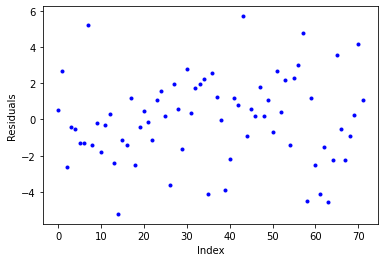

In [48]:
Res = Data3
list_type = ["A","B","C"]

for i in list_type:
    group = Res[Res[:,0] == i,1]
    Res[Res[:,0] == i,1] = group - np.mean(group)
    
plt.plot(Res[:,1],marker = ".",color="blue",linestyle="none")
plt.xlabel("Index")
plt.ylabel("Residuals")

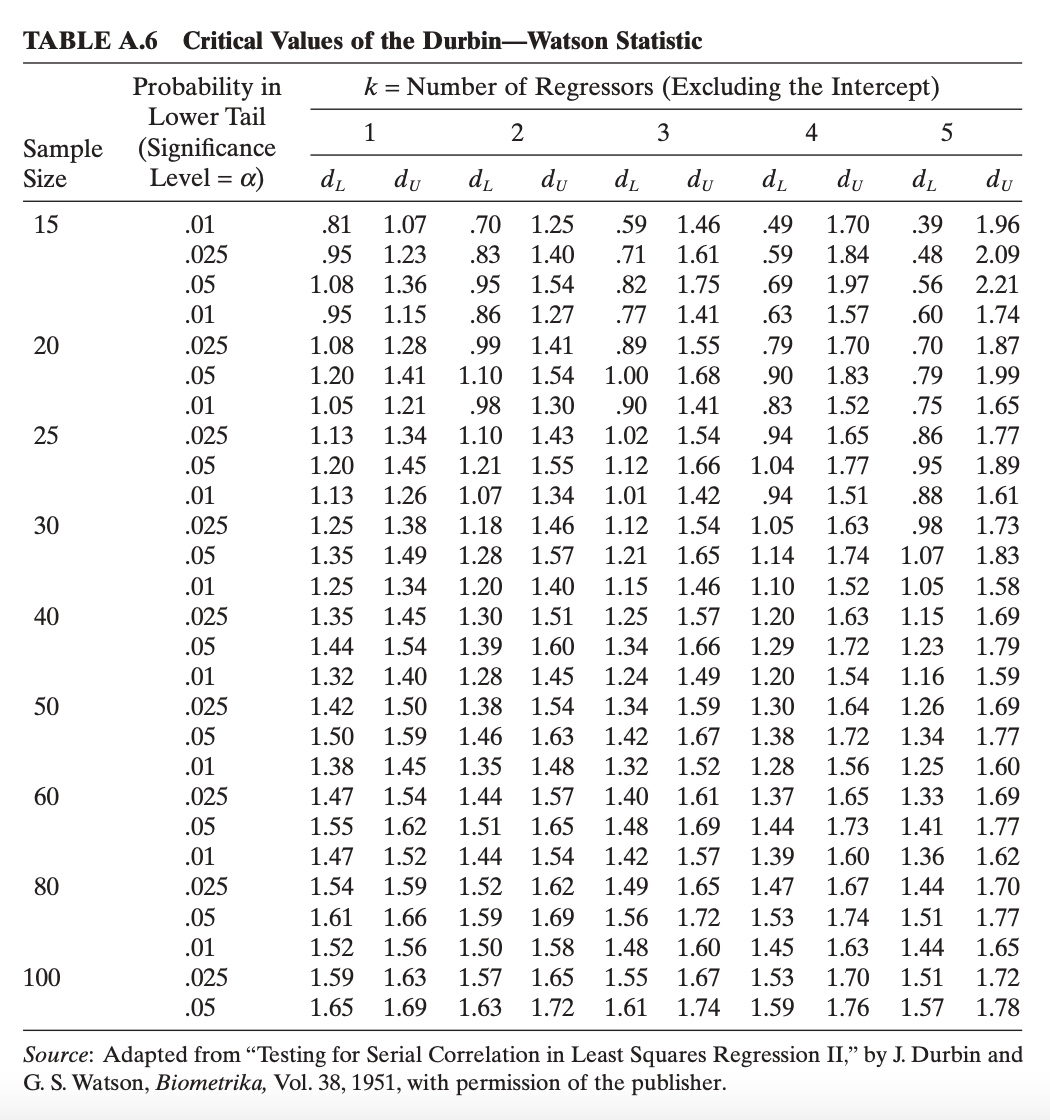#### 独立性检验

在实际应用中，验证数据具有独立性是一个很难的问题。一种常见具有**不独立**特点的数据具有自相关性。Durbin-Watson检验（简称“DW检验“）是一种检验序列是否存在一阶自相关性的常用方法。对于残差序列$\{e_i, i = 1,2,\cdots,n,\cdots\}$，考虑残差相关性方程为
$$
e_{i} = \rho e_{i-1} + v_{i}, \quad v_i \overset{i.i.d}{\sim} N(0,\sigma_v^2)，
$$
其中，$|\rho| < 1$。

在Durbin-Watson检验中，我们需要检验这样一对假设
$$
H_0 : \rho = 0 \quad \text{vs} \quad H_1: \rho > 0.
$$
可以注意到，$\rho = 0$表示残差序列无自相关性。也就是说，如果我们接受原假设，那么我们就认为序列数据是满足独立性的。

DW检验统计量为
$$
DW = \frac{\sum_{i=2}^n (e_i - e_{i-1})^2}{\sum_{i=1}^n e_{i}^2}
$$
可以注意到，$DW \approx 2(1-r_1)$，其中$r_1$表示一阶滞后样本自相关系数，即
$$
r_1 = \frac{\sum_{i=2}^{n} e_{i-1}e_{i}}{\sum_{i=1}^n e_{i}^2}.
$$
对于无相关性的残差序列，$r_1$接近于零，所以$DW$统计量接近于$2$。

判断规则为
- 如果 $DW < d_L$, 那么拒绝原假设；
- 如果 $DW > d_U$, 那么接受原假设；
- 如果 $d_L \leq DW \leq d_U$, 那么无法判断。

$d_L$和$d_U$与样本量、线性模型中特征个数以及显著性水平有关。具体可以查表，如下：![DW_table.jpg](./img/DW_table.jpg)
如果需要了解更多内容，可以阅读参考文献[1]-[3]。

接下来，我们看一下如何在python中实现Durbin Watson检验？
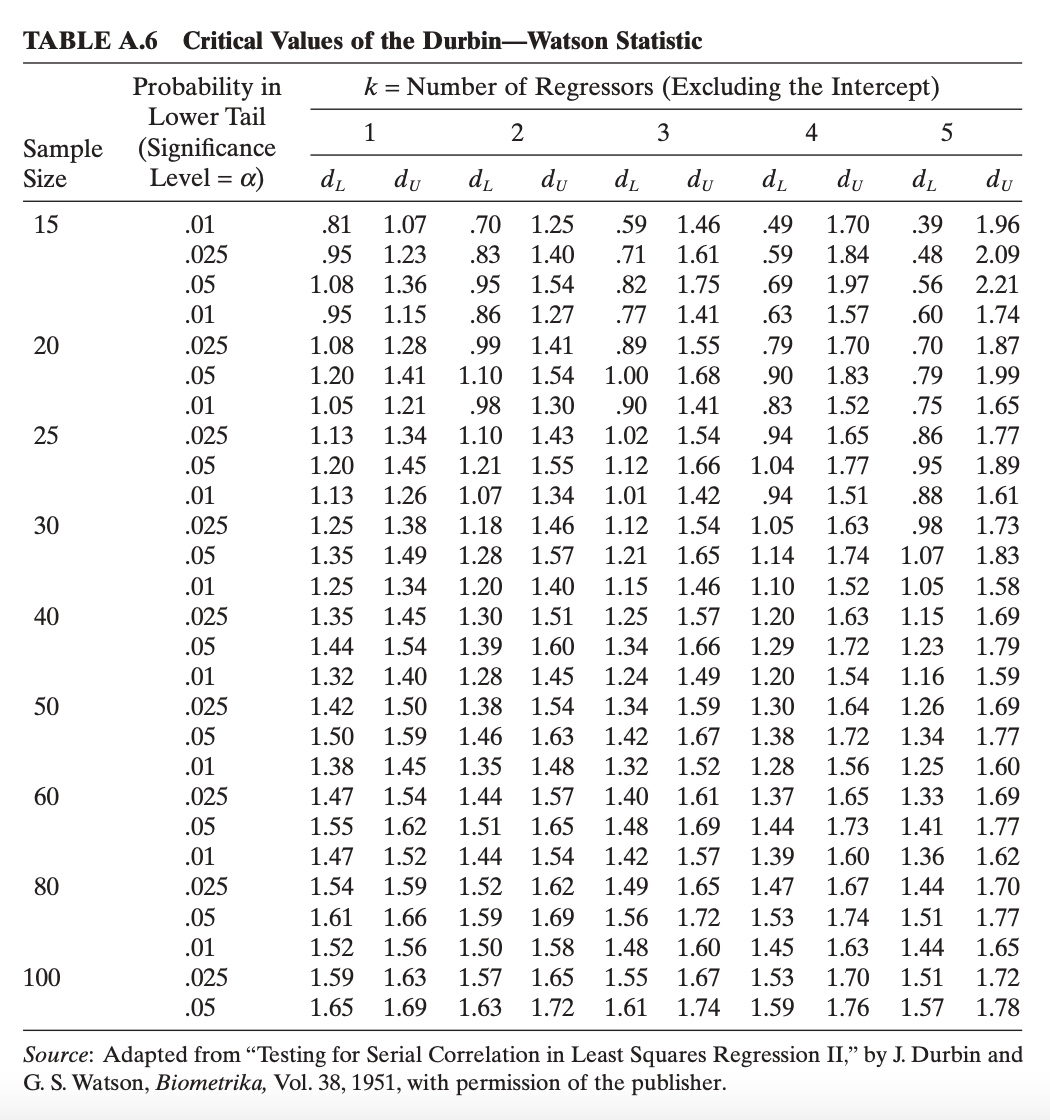

In [49]:
DW = durbin_watson(Res[:,1])
print(Res[:,1])
print("DW statistic is", round(DW,4))

[0.4999999999999978 2.7000000000000006 -2.5999999999999965
 -0.4000000000000008 -0.5000000000000022 -1.2999999999999994
 -1.2999999999999994 5.200000000000001 -1.3999999999999937
 -0.20000000000000506 -1.7999999999999994 -0.2999999999999994
 0.29999999999999494 -2.3999999999999937 -5.212500000000002
 -1.1125000000000003 -1.4124999999999974 1.187499999999997
 -2.512499999999999 -0.4124999999999974 0.48750000000000115
 -0.11250000000000027 -1.1125000000000003 1.0875000000000026
 1.5875000000000026 0.1874999999999969 -3.6125000000000003
 1.9625000000000012 0.5625000000000027 -1.6375000000000002
 2.7624999999999984 0.3624999999999998 1.7624999999999984
 1.9625000000000012 2.2624999999999984 -4.137499999999993
 2.5624999999999956 1.2624999999999984 -0.03749999999999876
 -3.8999999999999937 -2.200000000000005 1.2000000000000006
 0.7999999999999949 5.700000000000001 -0.8999999999999937
 0.6000000000000063 0.20000000000000062 1.799999999999995
 0.20000000000000062 1.0875000000000026 -0.7124999

在python中statsmodels.stats.stattools.durbin_watson()可以用于计算Durbin Watson检验统计量，但无法得到其临界值或者$p$值。还有一种较为**粗略**的判断方法：$DW$一般介于0到4之间。如果$DW$值接近于2，我们一般可以认为残差序列不具有相关性。

除了python之外，使用R语言也可以得到DW统计量，并可以输出相应的$p$值。具体代码如下：

In [ ]:
#### 以下需要切换到 R 语言，无须运行
#########################################################################
setwd("./Data")
data = read.csv("Data_1.csv",header=TRUE)

data$weight.loss = data$initial.weight - data$final.weight
mod = aov(weight.loss~diet.type,data)
res = residuals(mod)
library(lmtest,attach.required=TRUE)
dwtest(mod,alternative = "greater")


	Durbin-Watson test

data:  mod
DW = 1.9678, p-value = 0.3592
alternative hypothesis: true autocorrelation is greater than 0


#### 方差齐性检验

方差齐性检验的目的是判断各组数据的方差是否相等。对于第$i$组的数据而言，
$$
x_{ij} \sim N(\mu+\alpha_i, \sigma_i^2) , i=1,2,\cdots,a; j=1,2,\cdots,m_i.
$$
在方差齐性检验中，我们实际上提出了这样的一对假设
$$
H_0: \sigma_1^2 = \sigma_2^2 =\cdots = \sigma_a^2 \quad \text{vs}\quad H_1: \text{至少存在两组数据，$\sigma_i^2 \neq \sigma_j^2$}.
$$
接下来将介绍两种方差齐性的检验方法：Bartlett 检验和 修正后 Levene 检验。

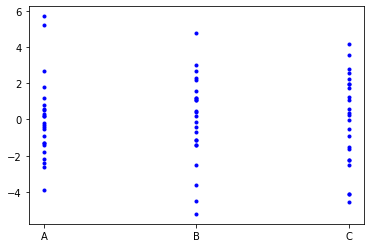

In [50]:
plt.plot(Res[:,0],Res[:,1],".",color="blue")

##### Bartlett检验
在Bartlett检验中，所使用的检验统计量为
$$
\chi_0^2 = 2.3026 \frac{q}{c}
$$
其中，
- $ q = (n - a) \log_{10}s_p^2 - \sum_{i=1}^a (m_i-1)  \log_{10}s_i^2 $；
- $c = 1 + \frac{1}{3(a-1)}\left( \sum_{i=1}^a (m_i-1)^{-1} - (n-a)^{-1} \right)$；
- $s_p^2 = \frac{\sum_{i}  (m_i-1)s^2_i}{n-a}$；
- $s_i^2$ 表示第$i$组数据的样本方差。

注意到，如果样本方差$s_i^2$差异大，那么$q$非常大；如果样本方差$s_i^2$完全一致，那么$q$为零。基于这个想法，如果检验统计量$\chi_0^2$过大，那么我们就拒绝原假设。具体来说，我们拒绝原假设当且仅当
$$
\chi_0^2 > \chi_{1-\alpha,a-1}^2
$$
其中$\chi_{1-\alpha,a-1}^2$是自由度为$a-1$的卡方分布的$1-\alpha$分位数。

然而，Bartlett检验存在一个**缺陷**：Bartlett检验对正态分布假定非常敏感。如果数据背离正态性假定，建议不要使用Bartlett检验。

In [51]:
# Bartlett's Test
Bart_stat, Bart_pVal = stats.bartlett(Group3_data[0], Group3_data[1], Group3_data[2])
print("Bartlett's test statistic is", round(Bart_stat,4))
print("The p value is", round(Bart_pVal,4))

Bartlett's test statistic is 0.2281
The p value is 0.8922


##### 修正后 Levene 检验

因为 Bartlett 对正态性假定的敏感性，所以对于背离正态性的数据，可以通过修正后的 Levene 检验来解决这个问题。令
$$
y_{ij}^{\ast} = |y_{ij} - \tilde{y}_{i}|, i = 1,2,\cdots,a; j = 1,2,\cdots,n_i.
$$
其中，$\tilde{y}_{i}$表示第$i$组数据的中位数。基于$\{y_{ij}^{\ast}\}$来构建$F$统计量。这个统计量可以用来评价每组数据的绝对偏差的均值是否相等，从而可以判断每组数据的波动是否一致。

In [52]:
Lev_stat, Lev_pVal = stats.levene(Group3_data[0], Group3_data[1], Group3_data[2])
print("Levene's test statistic is", round(Lev_stat,4))
print("The p value is", round(Lev_pVal,4))

Levene's test statistic is 0.5141
The p value is 0.6003


根据Bartlett检验和修正后Levene检验的结果，我们都可以断定残差满足方差齐性。

#### 正态性检验

我们仍可以先通过图象来判断数据是否满足正态性。为了验证数据是否满足某一假定分布，Quantile-Quantile图（简称“QQ图”）是最为常用的一种方法。其思想是：横坐标表示理论分布所对应的分位数，纵坐标表示经验分布所对应的分位数（样本分位数）。如果这些点是分布在一条直线上，那么可以判断数据服从该假定分布。

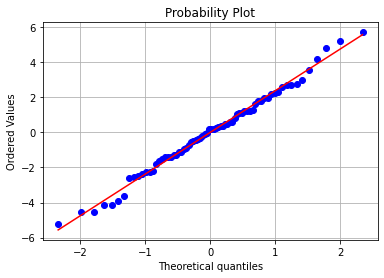

In [53]:
Res1 = Res[:,1].astype(float)
osm, osr = stats.probplot(Res1,dist= "norm",plot= plt)
plt.grid()
plt.show()

根据上图所示，总体上来看，残差分布可以认为是正态分布。

##### 补充：异常数据的检测方法
基于残差，我们可以构造标准化残差，即
$$
d_{ij} = \frac{e_{ij}}{\sqrt{MS_E}}
$$
一般而言，如果残差满足正态分布，那么
- 约 68\% 落在 $\pm 1$之内；
- 约 95\% 落在 $\pm 2$之内；
- 几乎全部落在 $\pm 3$之内。

如果标准化残差的绝对值大于3，那么所对应的数据可以判断为异常值。

##### Shapiro-Wilk 检验

假设数据$\{x_1,x_2,\cdots,x_n\}$来自正态总体$N(\mu,\sigma^2)$。令$x_{(1)}\leq x_{(2)}\leq \cdots \leq x_{(n)}$为其次序统计量。在Shapiro-Wilk 检验中，检验统计量为
$$
W = \frac{\left(\sum_{i=1}^n (a_{i}-\bar{a}) (x_{i}-\bar{x})\right)^2}{\sum_{i=1}^n (a_i-\bar{a})^2 \sum_{i=1}^n (x_{(i)} - \bar{x})^2}
$$
其中$a_1,a_2,\cdots,a_n$在给定样本量$n$时是一些特定的值。这里可以近似的看作“理论分位数”。于是，检验统计量$W$可以认为是理论分位数和样本分位数的相关系数的平方。如果它们约接近于一条直线，那么我们就认为数据是服从正态分布的。于是，我们所构造的拒绝域是$\{W\leq W_{\alpha}\}$。在实际数据分析中，我们可以用python代码来实现。

In [55]:
SW_stat,SW_pVal = stats.shapiro(Res1)
print("Shapiro-Wilk test statistic is", round(SW_stat,4))
print("The p value is", round(SW_pVal,4))

Shapiro-Wilk test statistic is 0.9902
The p value is 0.8557


根据上述分析，残差满足正态分布。

#### 参考文献

[1] Durbin, J., & Watson, G. S. (1950). Testing for Serial Correlation in Least Squares Regression: I. Biometrika, 37(3/4), 409–428. https://doi.org/10.2307/2332391

[2] Durbin, J., & Watson, G. S. (1951). Testing for Serial Correlation in Least Squares Regression. II. Biometrika, 38(1/2), 159–177. https://doi.org/10.2307/2332325

[3] Montgomery, D. C., Peck, E. A., & Vining, G. G. (2012). Introduction to linear regression analysis. John Wiley & Sons. (Chapter 14).

[4] Brown, M. B., & Forsythe, A. B. (1974). Robust tests for the equality of variances. Journal of the American statistical association, 69(346), 364-367.

[5] Montgomery D C. Design and analysis of experiments[M]. John wiley & sons, 2013. (Chapter 3).

[6] Shaphiro, S., & Wilk, M. B. J. B. (1965). An analysis of variance test for normality. Biometrika, 52(3), 591-611.